Testing CNN method from https://wandb.ai/mostafaibrahim17/ml-articles/reports/An-Introduction-to-Audio-Classification-with-Keras--Vmlldzo0MDQzNDUy#:~:text=%EF%BB%BFKeras%20is%20a%20go,both%20beginners%20and%20advanced%20users.

https://keras.io/guides/sequential_model/

In [37]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers # example functions: Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
from keras import Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import time

In [10]:
%run FeedingData.ipynb
# read Calvin's function files so we can call those functions from this notebook
# list of functions: 
# mfcc_(song, n=20)
# mfcc_cut(song, n=20, cutoff = 800)
# LFCC(song, n=20)
# LFCC_no_low(song, n=20, cutoff = 800)
# LFCC_no_low_clean(song, n=20, cutoff = 800)
# mfcc_cut_cleaned(song, n=20, cutoff = 800)
# main_freq(song, cutoff = 800)

In [11]:
def get_data(audio_path, meta_file, load_length, get_feature_function):
    songs_matrix = []
    songs_id = []
    df = pd.read_csv(meta_file)
    id_list = df.cat_num

    for name in id_list:
        filepath = os.path.join(audio_path, str(name)+'.wav')
        # skipping files that are less than 250 ~ 5sec long
        # this is to make sure we have enough length for sampling fft time intervals
        if os.path.getsize(filepath) < load_length*50000:
            continue
        # ============ load the data and get matrix ============
        # make sure that the size of the feature matrix is the same for all files
        song, sr = librosa.load(filepath, duration=load_length)
        features = get_feature_function(song, n = 40)
        songs_matrix.append(features)
        songs_id.append(name)
    return np.array(songs_matrix), songs_id

In [12]:
def get_labels(numbers, meta_file, label_name):
    # take in list of data id numbers and output their labels in label_name calssification
    df = pd.read_csv(meta_file)
    labels = []
    for num in numbers:
        labels.append(df[label_name].loc[df.cat_num == float(num)].item())
    return np.array(labels)

In [13]:
# for converting strings of label from one division to another, e.g. fam/subfam to critter name
def convert_labels(labels, meta_file, from_division, to_division):
    # find label in labels in meta_file under column from_division
    # append as key in dictionary lookup_table, append as value the corresponding label in to_division

    df = pd.read_csv(meta_file, usecols=[from_division, to_division])
    lookup_table = dict() # look up table for new label
    for label in labels:
        if label in lookup_table.keys():
            continue
        idx = df.loc[df[from_division]==label].index[0]
        lookup_table[label] = df[to_division][idx]
    return [lookup_table[label] for label in labels]

In [14]:
def remove_small_class(songs_matrix, songs_label, threshold):
    df_class = pd.DataFrame(np.unique(songs_label, return_counts=True)).T
    print('Data read:\n', df_class)
    # remove classes with too few data points
    small_class_list = []
    for row in range(len(df_class)):
        if df_class[1].iloc[row] < threshold:
            small_class_list.append(df_class[0].iloc[row].item())
    print('Removing classes:\n',small_class_list)
    delete_list = []
    for small_class in small_class_list:
        delete_list += list(np.where(songs_label==small_class)[0])

    short_label = np.delete(songs_label, delete_list)
    short_matrix = np.delete(songs_matrix, delete_list, 0)
    # double check data after deleting
    print('Reduced data:\n', pd.DataFrame(np.unique(short_label, return_counts=True)).T)
    return short_matrix, short_label

In [16]:
# load all audio in audio_path
# convert to matrix, save in np array, 
# load the corresponding label_name from lable_filename, save in another np array

audio_path = 'E:\chirpfiles\\no_voice_files'
meta_file = 'MLNS_05282024.csv'

start = time.time()
max_time = 5 # cut off time for loading, in sec
get_feature_function = mfcc_cut_cleaned
songs_matrix, songs_id = get_data(audio_path, meta_file, max_time, get_feature_function)
songs_label_critter = get_labels(songs_id, meta_file, 'critter_name')
songs_label_fam = get_labels(songs_id, meta_file, 'fam_or_subfam')
end = time.time()
print('time loading:', end - start)

C:\Users\sarah\AppData\Local\Temp\ipykernel_13572\2796635937.py:4: DtypeWarning: Columns (25,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(meta_file)
C:\Users\sarah\AppData\Local\Temp\ipykernel_13572\1885170622.py:3: DtypeWarning: Columns (25,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(meta_file)
C:\Users\sarah\AppData\Local\Temp\ipykernel_13572\1885170622.py:3: DtypeWarning: Columns (25,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(meta_file)


time loading: 242.04866075515747


In [17]:
np.save('songs_matrix_mfcc_cut_cleaned_5sec.npy', songs_matrix)
#np.save('songs_label_critter_5sec.npy', songs_label_critter)
#np.save('songs_label_fam_5sec.npy', songs_label_fam)
#np.save('songs_id_5sec.npy', songs_id)

In [18]:
# convert insec fam into numbers. use le.inverse_transform to go from number to name
le = LabelEncoder()
songs_label_num = le.fit_transform(songs_label_fam)
songs_label_onehot = to_categorical(songs_label_num) # required output format by cnn

# rename data/label variable name so that we don't need to change them in the model block
data_matrix = songs_matrix
data_label = songs_label_onehot

X_train, X_test, y_train, y_test = train_test_split(data_matrix, data_label, 
                                                    test_size = .2, random_state = 17)
# to use 2d convolution, keras model expects 4d input shape
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
print('Train test split train shape: ', X_train.shape)

X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, test_size = .2, random_state = 17)
print('Train validation split train shape: ', X_tt.shape)

Train test split train shape:  (4516, 40, 216, 1)
Train validation split train shape:  (3612, 40, 216, 1)


In [30]:
# make model 
input_shape =  (X_tt.shape[1], X_tt.shape[2],1,) # first dimension of train data is n_datapoints
model = Sequential() 
model.add(Input(input_shape))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=2))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(le.classes_), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

In [31]:
# train model
start = time.time()
epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(X_tt, y_tt, epochs=epochs, batch_size=64, 
                    validation_data=(X_val, y_val), callbacks=[early_stopping])
end = time.time()
print('time training: ', end - start)
#predicted_vector = model.predict(X_test)
#predicted_class_index = np.argmax(predicted_vector, axis=-1)
#le.inverse_transform(predicted_class_index)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 630ms/step - accuracy: 0.2330 - loss: 7.0214 - val_accuracy: 0.4093 - val_loss: 1.9246
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 626ms/step - accuracy: 0.4215 - loss: 1.8261 - val_accuracy: 0.4790 - val_loss: 1.6802
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 628ms/step - accuracy: 0.5051 - loss: 1.5372 - val_accuracy: 0.5100 - val_loss: 1.4939
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 627ms/step - accuracy: 0.5741 - loss: 1.3122 - val_accuracy: 0.5719 - val_loss: 1.3620
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 626ms/step - accuracy: 0.6299 - loss: 1.1237 - val_accuracy: 0.5608 - val_loss: 1.3571
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 624ms/step - accuracy: 0.6699 - loss: 0.9845 - val_accuracy: 0.5708 - val_loss: 1.3440
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 628ms/step - accuracy: 0.7160 - loss: 0.8401 - val_accuracy: 0.5564 - val_loss: 1.3854
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 624ms/step - accuracy: 0.7620 - loss: 0.7173 - val_accu

In [160]:
import pickle

with open('hist_mfcc_batch64_twohiddenlayer_5sec_critter.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(history, f)

# Getting back the objects:
#with open('hist_batch64_onehiddenlayer_5sec_critter.pkl') as f:  # Python 3: open(..., 'rb')
#    obj0, obj1, obj2 = pickle.load(f)

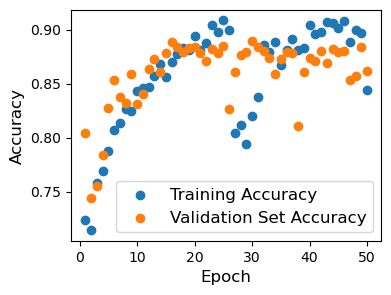

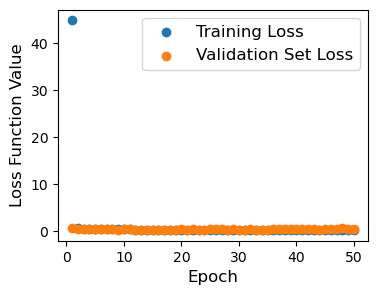

In [159]:
history_dict = h2.history
plt.figure(figsize = (4, 3))
plt.scatter(range(1,epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,epochs+1), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

plt.figure(figsize = (4, 3))

plt.scatter(range(1,epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,epochs+1), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

# vvv
### Report accuracy on validation set 

In [46]:
predicted_vector = model.predict(X_val)
predicted_class_index = np.argmax(predicted_vector, axis=-1)
pred_class = le.inverse_transform(predicted_class_index)
true_class_idx = np.where(y_val.astype(int))[1]
true_class = le.inverse_transform(true_class_idx)
print(true_class)
conf_mat = confusion_matrix(true_class, pred_class)
print(pd.DataFrame(conf_mat))#,
#                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
#                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
['Oecanthinae' 'Cicadidae' 'Trigonidiinae' 'Conocephalinae' 'Gryllinae'
 'Conocephalinae' 'Pseudophyllinae' 'Oecanthinae' 'Conocephalinae'
 'Conocephalinae' 'Gryllinae' 'Gryllinae' 'Tettigoniinae' 'Hapithinae'
 'Gryllinae' 'Phaneropterinae' 'Conocephalinae' 'Hapithinae' 'Hapithinae'
 'Conocephalinae' 'Pseudophyllinae' 'Hapithinae' 'Gryllinae'
 'Conocephalinae' 'Oecanthinae' 'Nemobiinae' 'Gryllinae' 'Hapithinae'
 'Phaneropterinae' 'Gryllinae' 'Conocephalinae' 'Gryllinae'
 'Phaneropterinae' 'Mogoplistinae' 'Pseudophyllinae' 'Gryllinae'
 'Gryllinae' 'Conocephalinae' 'Nemobiinae' 'Gryllinae' 'Hapithinae'
 'Phaneropterinae' 'Hapithinae' 'Gryllinae' 'Gryllinae' 'Trigonidiinae'
 'Gryllinae' 'Gryllinae' 'Phaneropterinae' 'Oecanthinae' 'Conocephalinae'
 'Tettigoniinae' 'Nemobiinae' 'Oecanthinae' 'Gryllotalpidae'
 'Conocephalinae' 'Conocephalinae' 'Nemobiinae' 'Cicadidae' 'Gryllinae'
 'Gryllinae' 'Gryllinae' 'Oecanthinae' 'Nemobiinae' 'Trigonidiinae'
 'Gry

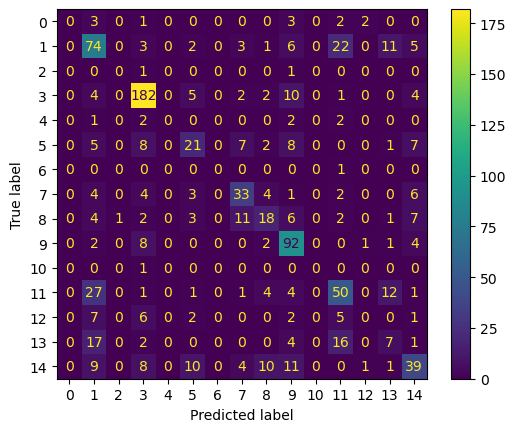

In [47]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix 
                                            = conf_mat)
cm_display.plot()
plt.show()

In [35]:
print(np.unique(true_class))
print(np.unique(pred_class))

['Cicadidae' 'Conocephalinae' 'Eneopterinae' 'Gryllinae' 'Gryllotalpidae'
 'Hapithinae' 'Listroscelidinae' 'Mogoplistinae' 'Nemobiinae'
 'Oecanthinae' 'Phalangopsidae' 'Phaneropterinae' 'Pseudophyllinae'
 'Tettigoniinae' 'Trigonidiinae']
['Cicadidae' 'Conocephalinae' 'Gryllinae' 'Hapithinae' 'Mogoplistinae'
 'Nemobiinae' 'Oecanthinae' 'Phaneropterinae' 'Pseudophyllinae'
 'Tettigoniinae' 'Trigonidiinae']


   0    1    2
0  0    8    3
1  0  567   28
2  1   68  229
accuracy = 0.8805309734513275


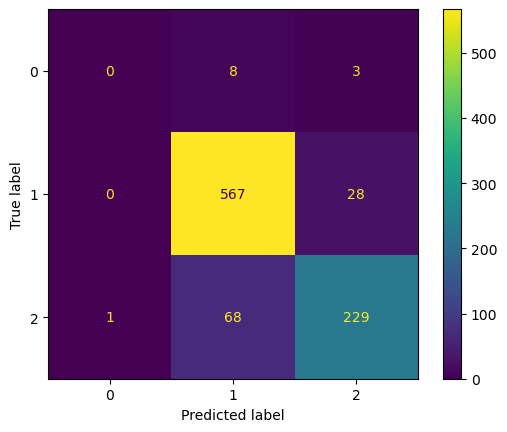

In [39]:
## to shorte list of classes after fitting on long list, use the class converter. 
label_name = 'fam_or_subfam'
true_class_short = convert_labels(true_class, meta_file, label_name, 'critter_name')
pred_class_short = convert_labels(pred_class, meta_file, label_name, 'critter_name')
conf_mat = confusion_matrix(true_class_short, pred_class_short)
print(pd.DataFrame(conf_mat))
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix 
                                            = conf_mat)
cm_display.plot()
plt.show()

# vvv 
### Forbidden test set block

In [88]:
predicted_vector = model.predict(X_test)
predicted_class_index = np.argmax(predicted_vector, axis=-1)

pred_class = le.inverse_transform(predicted_class_index)

true_class_idx = np.where(y_test.astype(int))[1]
true_class = le.inverse_transform(true_class_idx)
print(true_class)

conf_mat = confusion_matrix(true_class, pred_class)
print(pd.DataFrame(conf_mat))#,
#                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
#                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [70]:
## to shorte list of classes after fitting on long list, use the class converter. 
true_class_short = convert_labels(true_class, meta_file, label_name, 'critter_name')
pred_class_short = convert_labels(pred_class, meta_file, label_name, 'critter_name')

conf_mat = confusion_matrix(true_class_short, pred_class_short)
print(pd.DataFrame(conf_mat))
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

NameError: name 'to_divison' is not defined